In [16]:
import os
import numpy as np
import cv2
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.amp import GradScaler, autocast  # Updated import
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipykernel_1000/3295207783.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


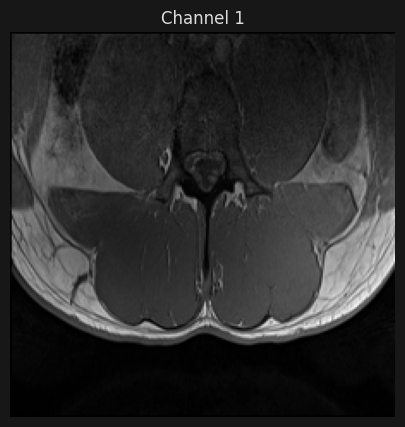

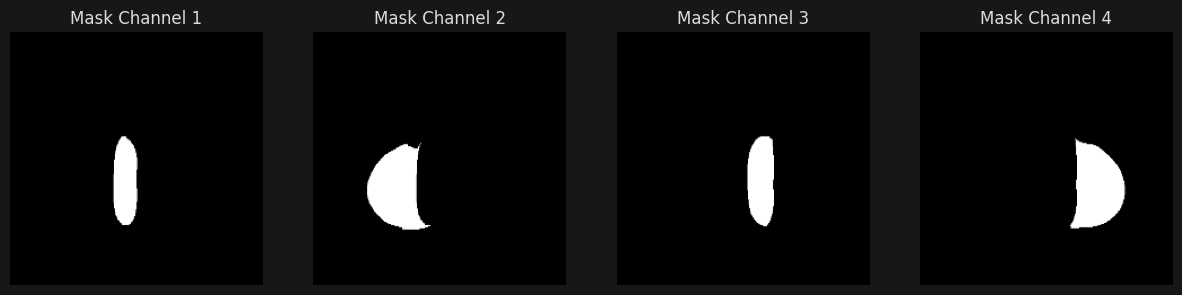

Mask shape before processing: (4, 224, 224)
Mask shape after processing: (4, 224, 224)


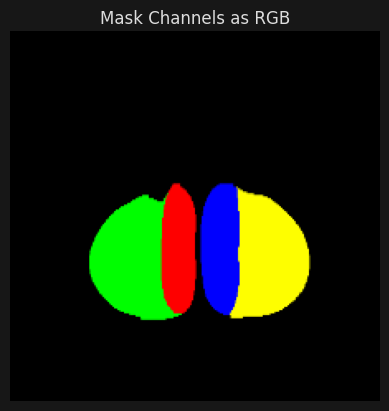

Image shape: (1, 224, 224)
Mask shape before processing: (4, 224, 224)
Mask shape after processing: (4, 224, 224)


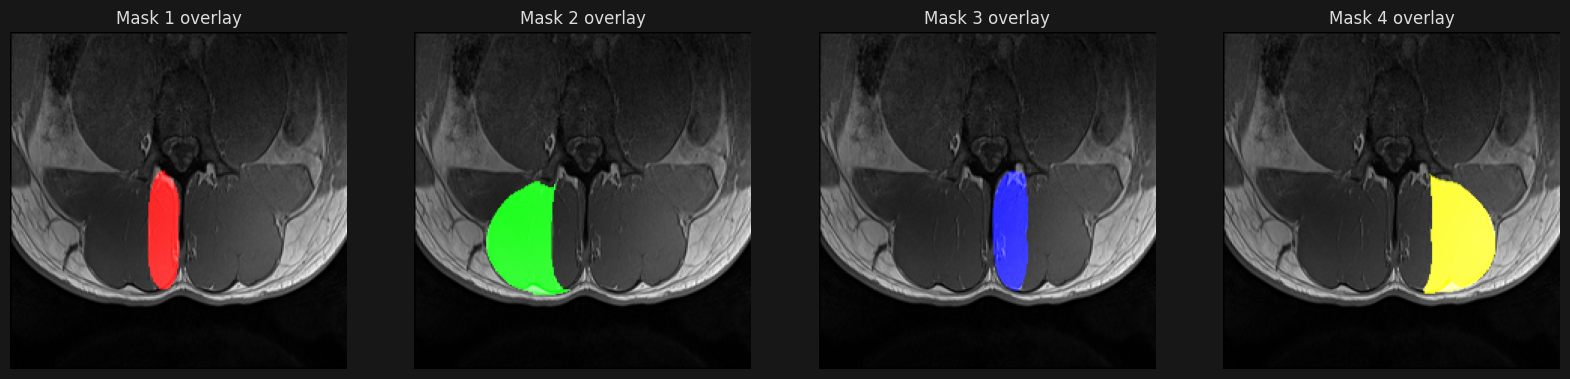

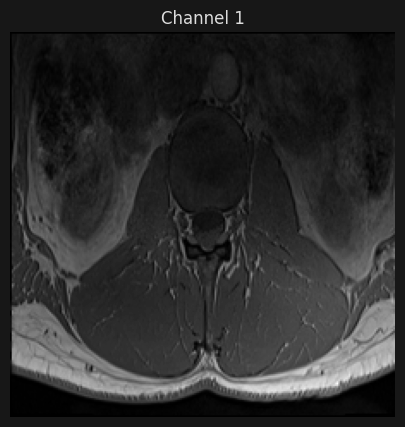

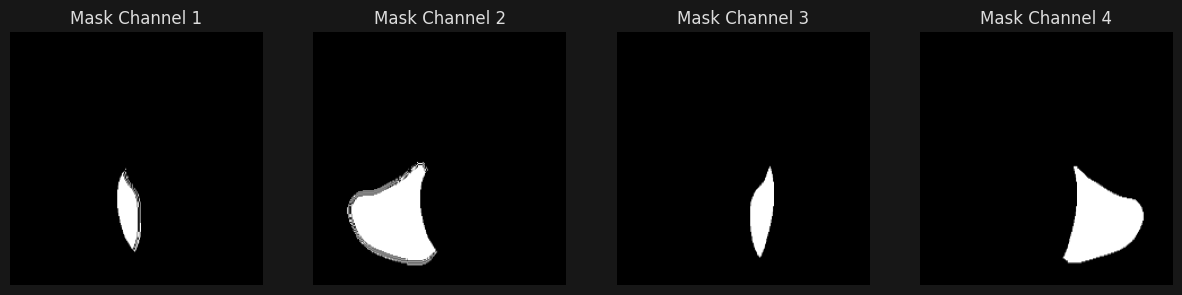

Mask shape before processing: (4, 224, 224)
Mask shape after processing: (4, 224, 224)


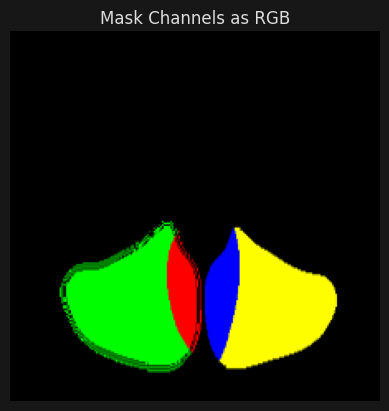

Image shape: (1, 224, 224)
Mask shape before processing: (4, 224, 224)
Mask shape after processing: (4, 224, 224)


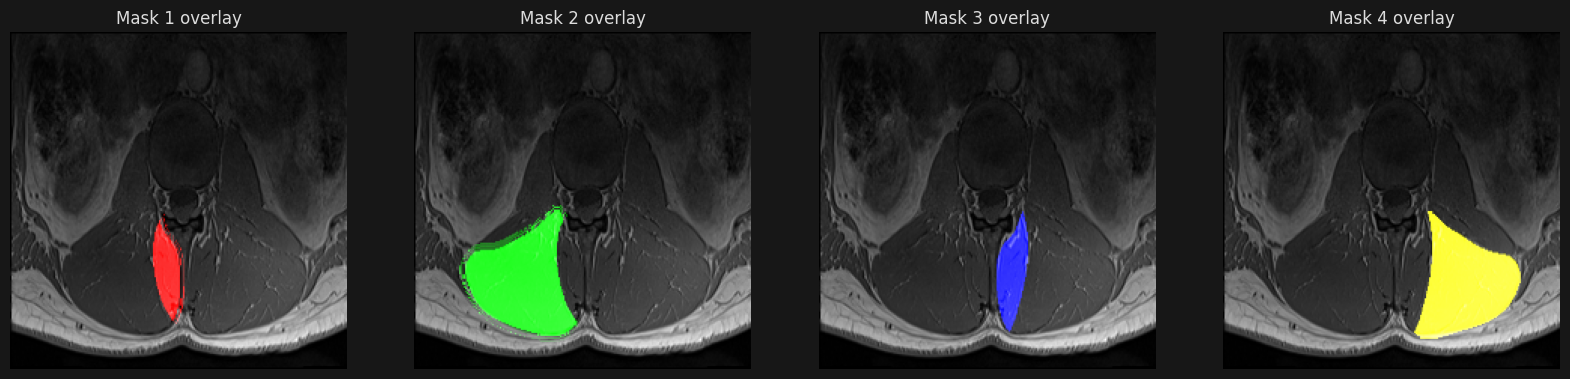

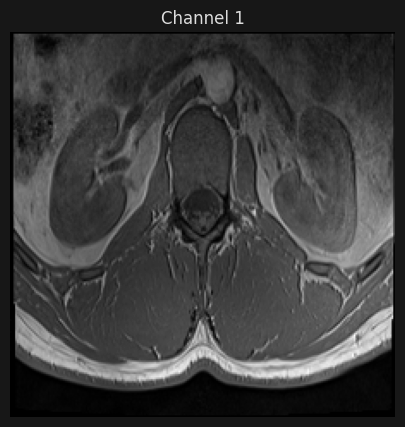

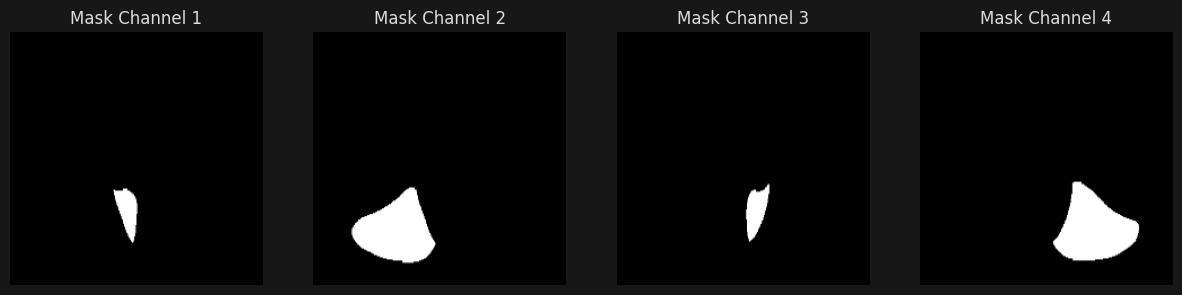

Mask shape before processing: (4, 224, 224)
Mask shape after processing: (4, 224, 224)


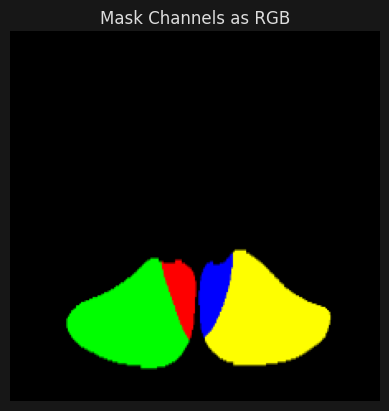

Image shape: (1, 224, 224)
Mask shape before processing: (4, 224, 224)
Mask shape after processing: (4, 224, 224)


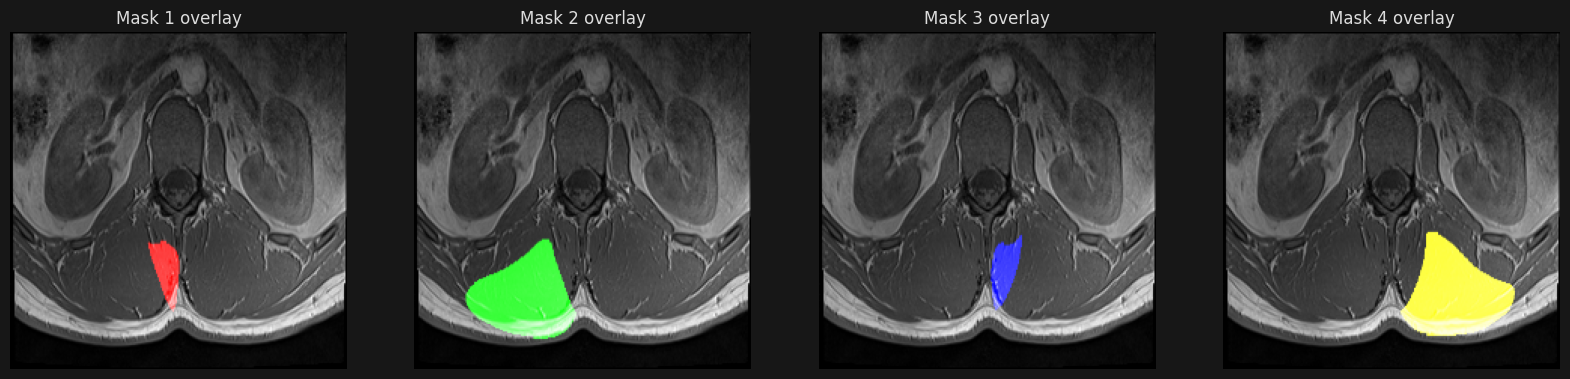

In [17]:
from torch.cuda.amp import GradScaler

scaler = GradScaler()

import torchvision.transforms as T
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from skimage import transform as sk_transform
import torch
from torch.utils.data import Dataset, DataLoader
import h5py

class PreprocessedHDF5Dataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.file_path = file_path
        self.transform = transform

        with h5py.File(self.file_path, 'r') as f:
            self.image_keys = list(f.keys())

    def __len__(self):
        return len(self.image_keys) // 2  # Assuming pairs of images and masks

    def __getitem__(self, idx):
        with h5py.File(self.file_path, 'r') as f:
            image = f[f'image_{idx}'][()]
            mask = f[f'mask_{idx}'][()]

        # Apply augmentation pipeline
        if self.transform:
            image, mask = self.transform(image, mask)

        return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

# # Example of how to integrate this augmentation pipeline in the dataset
# class PreprocessedHDF5Dataset(Dataset):
#     def __init__(self, file_path, transform=None):
#         self.file_path = file_path
#         self.transform = transform

#         with h5py.File(self.file_path, 'r') as f:
#             self.image_keys = list(f.keys())

#     def __len__(self):
#         return len(self.image_keys) // 2  # Assuming pairs of images and masks

#     def __getitem__(self, idx):
#         with h5py.File(self.file_path, 'r') as f:
#             image = f[f'image_{idx}'][()]
#             mask = f[f'mask_{idx}'][()]

#         # Apply augmentation pipeline
#         if self.transform:
#             image, mask = self.transform(image, mask)

#         return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)


def display_image_channels(image):
    """Display each channel of the image."""
    num_channels = image.shape[0]
    fig, axes = plt.subplots(1, num_channels, figsize=(15, 5))
    if num_channels == 1:
        axes.imshow(image[0], cmap='gray')
        axes.set_title('Channel 1')
        axes.axis('off')
    else:
        for i in range(num_channels):
            axes[i].imshow(image[i], cmap='gray')
            axes[i].set_title(f'Channel {i+1}')
            axes[i].axis('off')
    plt.show()

def display_mask_channels_as_grayscale(mask):
    """Display original mask channels as grayscale."""
    num_channels = mask.shape[0]
    fig, axes = plt.subplots(1, num_channels, figsize=(15, 5))
    for i in range(num_channels):
        axes[i].imshow(mask[i], cmap='gray')
        axes[i].set_title(f'Mask Channel {i+1}')
        axes[i].axis('off')
    plt.show()

def display_mask_channels_as_rgb(mask):
    """Display mask channels as RGB with the fourth channel as a different color overlay."""
    print("Mask shape before processing:", mask.shape)  # Debug information

    # Ensure mask has at least 3 dimensions
    if mask.ndim == 2:
        mask = np.expand_dims(mask, axis=0)

    # Normalize mask channels to [0, 1] range
    mask = mask - mask.min(axis=(1, 2), keepdims=True)
    mask = mask / (mask.max(axis=(1, 2), keepdims=True) + 1e-4)

    print("Mask shape after processing:", mask.shape)  # Debug information

    # Take the first three channels to display as RGB
    mask_rgb = np.zeros((mask.shape[1], mask.shape[2], 3))
    for i in range(min(3, mask.shape[0])):
        mask_rgb[..., i] = mask[i]
    
    # Overlay the fourth mask channel if it exists
    if mask.shape[0] > 3:
        fourth_mask = mask[3]
        yellow_overlay = np.stack((fourth_mask, fourth_mask, np.zeros_like(fourth_mask)), axis=-1)
        mask_rgb = np.maximum(mask_rgb, yellow_overlay)

    plt.imshow(mask_rgb)
    plt.title('Mask Channels as RGB')
    plt.axis('off')
    plt.show()

def overlay_masks_on_image(image, mask):
    """Overlay masks on the image."""
    print("Image shape:", image.shape)  # Debug information
    print("Mask shape before processing:", mask.shape)  # Debug information
    
    if image.shape[0] != 1:
        raise ValueError("Image should have a single channel for overlaying masks")

    # Normalize image to [0, 1] range
    image = image - image.min()
    image = image / (image.max() + 1e-4)

    # Prepare an RGB image for overlay
    image_rgb = np.stack((image[0], image[0], image[0]), axis=-1)

    # Ensure mask has at least 3 dimensions
    if mask.ndim == 2:
        mask = np.expand_dims(mask, axis=0)
    
    # Normalize mask channels to [0, 1] range
    mask = mask - mask.min(axis=(1, 2), keepdims=True)
    mask = mask / (mask.max(axis=(1, 2), keepdims=True) + 1e-4)

    print("Mask shape after processing:", mask.shape)  # Debug information

    # Overlay each mask channel on the image
    colors = ['red', 'green', 'blue', 'yellow']
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for i in range(4):
        overlay = image_rgb.copy()
        color_mask = np.zeros_like(image_rgb)
        if i < mask.shape[0]:  # Check to ensure there are enough mask channels
            if colors[i] == 'red':
                color_mask[..., 0] = mask[i]
            elif colors[i] == 'green':
                color_mask[..., 1] = mask[i]
            elif colors[i] == 'blue':
                color_mask[..., 2] = mask[i]
            elif colors[i] == 'yellow':
                color_mask[..., 0] = mask[i]
                color_mask[..., 1] = mask[i]
        overlay = np.maximum(overlay, color_mask)
        
        axes[i].imshow(overlay)
        axes[i].set_title(f'Mask {i+1} overlay')
        axes[i].axis('off')
    plt.show()

def display_multiple_images_with_masks(dataloader, num_images=5):
    """Display multiple images with their corresponding masks."""
    count = 0
    for images, masks in dataloader:
        batch_size = images.shape[0]
        for i in range(batch_size):
            if count >= num_images:
                return
            
            image = images[i].numpy()
            mask = masks[i].numpy()
            
            print(f"Displaying image {count + 1}")
            display_image_channels(image)
            display_mask_channels_as_grayscale(mask)  # Display original mask channels as grayscale
            display_mask_channels_as_rgb(mask)
            overlay_masks_on_image(image, mask)
            
            count += 1

# Load the preprocessed dataset
data_path = '/mnt/d/data/data_preprocessed.hdf5'
batch_size = 16
preprocessed_dataset = PreprocessedHDF5Dataset(data_path)
dataloader = DataLoader(preprocessed_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Check and display a few sample pairs
for images, masks in dataloader:
    for i in range(min(3, len(images))):
        display_image_channels(images[i].numpy())
        display_mask_channels_as_grayscale(masks[i].numpy())
        display_mask_channels_as_rgb(masks[i].numpy())
        overlay_masks_on_image(images[i].numpy(), masks[i].numpy())
    break  # Display only the first batch for debugging|

In [18]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from tqdm import tqdm
import cv2
from torch.cuda.amp import GradScaler, autocast
import h5py
import os
from torch.utils.data import Dataset


# Dataset for loading preprocessed data from HDF5
class PreprocessedHDF5Dataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.file_path = file_path
        self.transform = transform

        with h5py.File(self.file_path, 'r') as f:
            self.image_keys = list(f.keys())

    def __len__(self):
        return len(self.image_keys) // 2  # Assuming pairs of images and masks

    def __getitem__(self, idx):
        with h5py.File(self.file_path, 'r') as f:
            image = f[f'image_{idx}'][()]
            mask = f[f'mask_{idx}'][()]

        image = (image - image.min()) / (image.max() - image.min() + 1e-8)
        
        if self.transform:
            image, mask = self.transform(image, mask)

        return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

# Squeeze-and-Excitation Block
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        batch_size, channels, _, _ = x.size()
        # Global average pooling (squeeze)
        y = x.view(batch_size, channels, -1).mean(dim=2)
        # Fully connected layers
        y = self.fc1(y)
        y = F.relu(y)
        y = self.fc2(y)
        y = torch.sigmoid(y).view(batch_size, channels, 1, 1)
        # Scale input by learned weights
        return x * y.expand_as(x)

# Residual Encoder Block with SE Block
class ResidualEncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU(), use_se_block=True):
        super(ResidualEncoderBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.activation = activation
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se_block = SEBlock(out_channels) if use_se_block else nn.Identity()

        # Residual connection to match dimensions
        self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        identity = self.residual(x)  # Residual connection
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se_block(out)  # Apply SE block for channel-wise attention
        out += identity  # Add the residual connection
        out = self.activation(out)
        return out

# Residual Decoder Block with SE Block
class ResidualDecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU(), use_se_block=True):
        super(ResidualDecoderBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.activation = activation
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se_block = SEBlock(out_channels) if use_se_block else nn.Identity()

        # Residual connection to match dimensions
        self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        identity = self.residual(x)  # Residual connection
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se_block(out)  # Apply SE block for channel-wise attention
        out += identity  # Add the residual connection
        out = self.activation(out)
        return out

# Residual U-Net with SE Blocks
class ResidualUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=4, base_filters=32, use_se_block=True):
        super(ResidualUNet, self).__init__()

        self.downsample = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.enc_block_1 = ResidualEncoderBlock(in_channels, base_filters, use_se_block=use_se_block)
        self.enc_block_2 = ResidualEncoderBlock(base_filters, base_filters * 2, use_se_block=use_se_block)
        self.enc_block_3 = ResidualEncoderBlock(base_filters * 2, base_filters * 4, use_se_block=use_se_block)
        self.enc_block_4 = ResidualEncoderBlock(base_filters * 4, base_filters * 8, use_se_block=use_se_block)

        self.bottleneck = ResidualEncoderBlock(base_filters * 8, base_filters * 16, use_se_block=use_se_block)

        self.dec_block_4 = ResidualDecoderBlock(base_filters * 16 + base_filters * 8, base_filters * 8, use_se_block=use_se_block)
        self.dec_block_3 = ResidualDecoderBlock(base_filters * 8 + base_filters * 4, base_filters * 4, use_se_block=use_se_block)
        self.dec_block_2 = ResidualDecoderBlock(base_filters * 4 + base_filters * 2, base_filters * 2, use_se_block=use_se_block)
        self.dec_block_1 = ResidualDecoderBlock(base_filters * 2 + base_filters, base_filters, use_se_block=use_se_block)

        self.output_conv = nn.Conv2d(base_filters, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder path
        skip_1 = self.enc_block_1(x)
        x = self.downsample(skip_1)
        skip_2 = self.enc_block_2(x)
        x = self.downsample(skip_2)
        skip_3 = self.enc_block_3(x)
        x = self.downsample(skip_3)
        skip_4 = self.enc_block_4(x)
        x = self.downsample(skip_4)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder path with concatenation of skip connections
        x = self.upsample(x)
        x = torch.cat([x, skip_4], dim=1)  # Skip connection from enc_block_4
        x = self.dec_block_4(x)

        x = self.upsample(x)
        x = torch.cat([x, skip_3], dim=1)  # Skip connection from enc_block_3
        x = self.dec_block_3(x)

        x = self.upsample(x)
        x = torch.cat([x, skip_2], dim=1)  # Skip connection from enc_block_2
        x = self.dec_block_2(x)

        x = self.upsample(x)
        x = torch.cat([x, skip_1], dim=1)  # Skip connection from enc_block_1
        x = self.dec_block_1(x)

        # Output layer
        x = self.output_conv(x)
        return x


In [24]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice


def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f'Total Parameters: {total_params:,}\n')


def save_checkpoint(model, optimizer, scheduler, epoch, checkpoint_dir='checkpoints', filename='res75_checkpoint.pth'):
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, filename)
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint, checkpoint_path)
    print(f'Checkpoint saved at epoch {epoch} to {checkpoint_path}')


def load_checkpoint(model, optimizer, scheduler, checkpoint_dir='checkpoints', filename='res_checkpoint.pth'):
    """
    Loads the training checkpoint.

    Args:
        model (nn.Module): The model to load.
        optimizer (torch.optim.Optimizer): The optimizer.
        scheduler (torch.optim.lr_scheduler._LRScheduler): The learning rate scheduler.
        checkpoint_dir (str): Directory where the checkpoint is saved.
        filename (str): Filename of the checkpoint.

    Returns:
        int: The epoch to resume training from.
    """
    checkpoint_path = os.path.join(checkpoint_dir, filename)
    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location='cpu')  # Adjust map_location if needed
        try:
            model.load_state_dict(checkpoint['model_state_dict'], strict=True)
            print(f"Successfully loaded model weights from {checkpoint_path}")
        except RuntimeError as e:
            print(f"Error loading model weights: {e}")
            return 0  # Or handle as appropriate
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        epoch = checkpoint['epoch']
        print(f'Checkpoint loaded from {checkpoint_path} at epoch {epoch}')
        return epoch
    else:
        print(f'No checkpoint found at {checkpoint_path}')
        return 0



def dice_coefficient(preds, targets, num_classes, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()

    kernel = np.ones((5, 5), np.uint8)
    for i in range(preds.shape[0]):
        for j in range(num_classes):
            mask = preds[i, j].cpu().numpy().astype(np.uint8)
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
            preds[i, j] = torch.tensor(mask, dtype=torch.float32, device=preds.device)

    dice_scores = []
    for i in range(num_classes):
        pred_i = preds[:, i, :, :]
        target_i = targets[:, i, :, :].float()

        intersection = (pred_i * target_i).sum(dim=(1, 2))
        union = pred_i.sum(dim=(1, 2)) + target_i.sum(dim=(1, 2))

        dice = (2. * intersection + 1e-6) / (union + 1e-6)
        dice_scores.append(dice.mean().item())

    return dice_scores


def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f'Model saved to {filepath}')


In [25]:
def plot_losses(train_losses, val_losses):
    sns.set(style="whitegrid")
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 7))
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss', markersize=7, linewidth=2)
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss', markersize=7, linewidth=2)

    plt.title('Training and Validation Loss Over Epochs', fontsize=18, fontweight='bold')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc='upper right', fontsize=14, frameon=True, shadow=True)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()


def plot_dice_scores(train_dice_scores, val_dice_scores, num_classes=4):
    sns.set(style="whitegrid")
    epochs = range(1, len(train_dice_scores) + 1)

    plt.figure(figsize=(12, 7))

    colors = sns.color_palette("husl", num_classes)
    markers = ['o', 's', '^', 'D', '*', 'x', '+']

    for class_idx in range(num_classes):
        train_class_scores = [epoch_scores[class_idx] for epoch_scores in train_dice_scores]
        val_class_scores = [epoch_scores[class_idx] for epoch_scores in val_dice_scores]

        plt.plot(epochs, train_class_scores, color=colors[class_idx],
                 marker=markers[class_idx % len(markers)], linewidth=2, markersize=7,
                 label=f'Training Dice Score (Class {class_idx + 1})')
        plt.plot(epochs, val_class_scores, color=colors[class_idx],
                 marker=markers[class_idx % len(markers)], linestyle='--', linewidth=2, markersize=7,
                 label=f'Validation Dice Score (Class {class_idx + 1})')

    plt.title('Dice Score Over Epochs for Each Class', fontsize=18, fontweight='bold')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Dice Score', fontsize=16)
    plt.legend(loc='upper left', fontsize=12, frameon=True, shadow=True, ncol=2)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()


def create_overlay(image, mask):
    """Create an overlay of the mask on the image."""
    image_rgb = np.repeat(image[..., np.newaxis], 3, axis=-1)  # Convert grayscale to RGB
    mask_rgb = np.zeros_like(image_rgb)
    for i in range(min(3, mask.shape[0])):
        mask_rgb[..., i] = mask[i]
    if mask.shape[0] > 3:
        fourth_mask = mask[3]
        yellow_overlay = np.stack((fourth_mask, fourth_mask, np.zeros_like(fourth_mask)), axis=-1)
        mask_rgb = np.maximum(mask_rgb, yellow_overlay)
    overlay = 0.6 * image_rgb + 0.4 * mask_rgb
    return overlay / overlay.max()


def display_test_samples(model, test_inputs, test_targets, device, num_images_to_display=None):
    test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)

    # Obtain the model's prediction
    model.eval()
    with torch.no_grad():
        test_preds = torch.sigmoid(model(test_inputs))

    # Threshold predictions to binary masks
    threshold = 0.5
    test_preds_binary = (test_preds > threshold).float()

    # Post-processing: Apply Gaussian smoothing and morphological operations
    kernel = np.ones((5, 5), np.uint8)
    larger_kernel = np.ones((7, 7), np.uint8)  # Larger kernel for smoothing
    for i in range(test_preds_binary.shape[0]):  # Iterate over batch size
        for j in range(test_preds_binary.shape[1]):  # Iterate over classes
            mask = test_preds_binary[i, j].detach().cpu().numpy().astype(np.uint8)
            mask = cv2.GaussianBlur(mask, (7, 7), 0)  # Apply larger Gaussian smoothing
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, larger_kernel)  # Closing operation
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, larger_kernel)  # Opening operation
            test_preds_binary[i, j] = torch.tensor(mask, dtype=torch.float32, device=test_preds_binary.device)

    # Process the images and masks for visualization
    images = test_inputs.detach().cpu().numpy()
    masks_pred = test_preds_binary.detach().cpu().numpy()
    masks_target = test_targets.detach().cpu().numpy()

    if num_images_to_display is not None:
        images = images[:num_images_to_display]
        masks_pred = masks_pred[:num_images_to_display]
        masks_target = masks_target[:num_images_to_display]

    num_images = images.shape[0]

    # Set the plot aesthetics
    plt.rcParams['figure.facecolor'] = '#171717'
    plt.rcParams['text.color'] = '#DDDDDD'

    # Display each image with its predicted and ground truth masks and overlays
    for i in range(num_images):
        fig, axes = plt.subplots(1, 5, figsize=(25, 5))

        # Display the input image
        ax = axes[0]
        ax.imshow(images[i][0], cmap='gray')
        ax.set_title(f'Image {i+1}')
        ax.axis('off')

        # Display the predicted mask
        mask_pred = masks_pred[i]
        mask_rgb = np.zeros((mask_pred.shape[1], mask_pred.shape[2], 3))
        for j in range(min(3, mask_pred.shape[0])):
            mask_rgb[..., j] = mask_pred[j]
        if mask_pred.shape[0] > 3:
            fourth_mask = mask_pred[3]
            yellow_overlay = np.stack((fourth_mask, fourth_mask, np.zeros_like(fourth_mask)), axis=-1)
            mask_rgb = np.maximum(mask_rgb, yellow_overlay)
        ax = axes[1]
        ax.imshow(mask_rgb)
        ax.set_title(f'Predicted Mask {i+1}')
        ax.axis('off')

        # Display the ground truth mask
        mask_target = masks_target[i]
        mask_rgb = np.zeros((mask_target.shape[1], mask_target.shape[2], 3))
        for j in range(min(3, mask_target.shape[0])):
            mask_rgb[..., j] = mask_target[j]
        if mask_target.shape[0] > 3:
            fourth_mask = mask_target[3]
            yellow_overlay = np.stack((fourth_mask, fourth_mask, np.zeros_like(fourth_mask)), axis=-1)
            mask_rgb = np.maximum(mask_rgb, yellow_overlay)
        ax = axes[2]
        ax.imshow(mask_rgb)
        ax.set_title(f'Ground Truth {i+1}')
        ax.axis('off')

        # Display the overlay of predicted mask on the original image
        overlay_pred = create_overlay(images[i][0], masks_pred[i])
        ax = axes[3]
        ax.imshow(overlay_pred)
        ax.set_title(f'Overlay Predicted {i+1}')
        ax.axis('off')

        # Display the overlay of ground truth mask on the original image
        overlay_target = create_overlay(images[i][0], masks_target[i])
        ax = axes[4]
        ax.imshow(overlay_target)
        ax.set_title(f'Overlay Ground Truth {i+1}')
        ax.axis('off')

        plt.show()


Total Parameters: 8,344,864

cuda


/tmp/ipykernel_1000/3256446826.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cpu')  # Adjust map_location if ne

Successfully loaded model weights from checkpoints/res_checkpoint.pth
Checkpoint loaded from checkpoints/res_checkpoint.pth at epoch 50
Learning rate reset to 0.001
Training...


Epoch: 51, Train loss: 9.607570, Val loss: 8.483135, Train Dice: 52.792786, Val Dice: 54.050827, lr 1.000000e-03


Epoch: 52, Train loss: 9.718016, Val loss: 8.030926, Train Dice: 52.724928, Val Dice: 54.414016, lr 1.000000e-03


Epoch: 53, Train loss: 9.498823, Val loss: 8.320626, Train Dice: 52.735758, Val Dice: 54.067325, lr 1.000000e-03


Epoch: 54, Train loss: 9.807819, Val loss: 8.015810, Train Dice: 52.791471, Val Dice: 54.445854, lr 1.000000e-04


Epoch: 55, Train loss: 9.437513, Val loss: 7.810907, Train Dice: 53.245974, Val Dice: 54.575251, lr 1.000000e-04
Checkpoint saved at epoch 55 to checkpoints/res75_checkpoint.pth


Epoch: 56, Train loss: 9.478410, Val loss: 7.819984, Train Dice: 52.763987, Val Dice: 54.627365, lr 1.000000e-04


Epoch: 57, Train loss: 9.257121, Val loss: 7.714556, Train Dice: 53.069971, Val Dice: 54.737663, lr 1.000000e-04


Epoch: 58, Train loss: 9.145376, Val loss: 7.677727, Train Dice: 53.291706, Val Dice: 54.726585, lr 1.000000e-04


Epoch: 59, Train loss: 9.446877, Val loss: 7.649057, Train Dice: 52.983680, Val Dice: 54.738847, lr 1.000000e-04


Epoch: 60, Train loss: 9.230455, Val loss: 7.641819, Train Dice: 53.324932, Val Dice: 54.790007, lr 1.000000e-04
Checkpoint saved at epoch 60 to checkpoints/res75_checkpoint.pth


Epoch: 61, Train loss: 9.288026, Val loss: 7.649285, Train Dice: 53.445132, Val Dice: 54.848025, lr 1.000000e-04


Epoch: 62, Train loss: 8.976857, Val loss: 7.624720, Train Dice: 53.725112, Val Dice: 54.857915, lr 1.000000e-04


Epoch: 63, Train loss: 8.841782, Val loss: 7.570198, Train Dice: 53.559477, Val Dice: 54.883653, lr 1.000000e-04


Epoch: 64, Train loss: 9.217210, Val loss: 7.558891, Train Dice: 53.174511, Val Dice: 54.872749, lr 1.000000e-04


Epoch: 65, Train loss: 9.295122, Val loss: 7.492026, Train Dice: 53.267874, Val Dice: 54.923707, lr 1.000000e-04
Checkpoint saved at epoch 65 to checkpoints/res75_checkpoint.pth


Epoch: 66, Train loss: 8.929760, Val loss: 7.474612, Train Dice: 53.510783, Val Dice: 54.939324, lr 1.000000e-04


Epoch: 67, Train loss: 9.100642, Val loss: 7.465625, Train Dice: 53.723274, Val Dice: 54.999240, lr 1.000000e-04


Epoch: 68, Train loss: 9.218853, Val loss: 7.490137, Train Dice: 52.972277, Val Dice: 54.971622, lr 1.000000e-04


Epoch: 69, Train loss: 9.268087, Val loss: 7.552793, Train Dice: 53.278842, Val Dice: 54.943057, lr 1.000000e-04


Epoch: 70, Train loss: 9.210439, Val loss: 7.467411, Train Dice: 53.084632, Val Dice: 54.986308, lr 1.000000e-04
Checkpoint saved at epoch 70 to checkpoints/res75_checkpoint.pth


Epoch: 71, Train loss: 9.055123, Val loss: 7.489314, Train Dice: 53.514199, Val Dice: 55.009501, lr 1.000000e-05


Epoch: 72, Train loss: 9.036634, Val loss: 7.457321, Train Dice: 53.050237, Val Dice: 55.067635, lr 1.000000e-05


Epoch: 73, Train loss: 8.994461, Val loss: 7.441550, Train Dice: 53.327238, Val Dice: 55.036177, lr 1.000000e-05


Epoch: 74, Train loss: 9.113564, Val loss: 7.436730, Train Dice: 53.326079, Val Dice: 55.070772, lr 1.000000e-05


Epoch: 75, Train loss: 9.026765, Val loss: 7.446278, Train Dice: 53.423528, Val Dice: 55.043441, lr 1.000000e-05
Checkpoint saved at epoch 75 to checkpoints/res75_checkpoint.pth
Model saved to /mnt/d/data/clean75_unet_model.pth


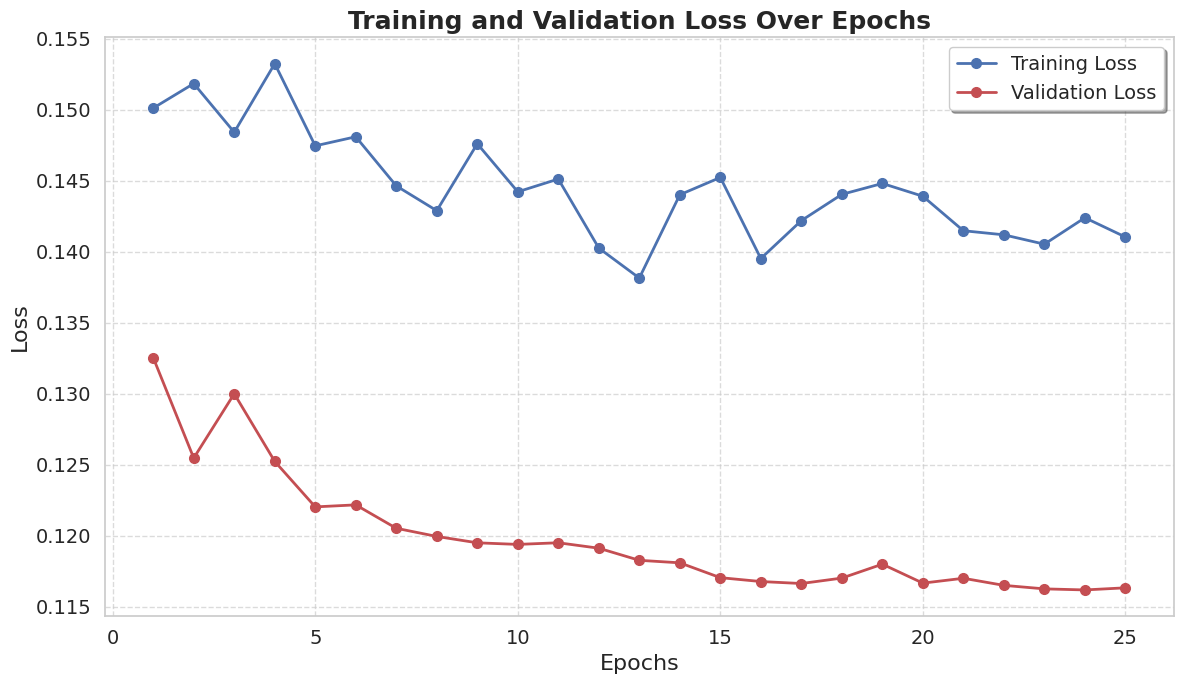

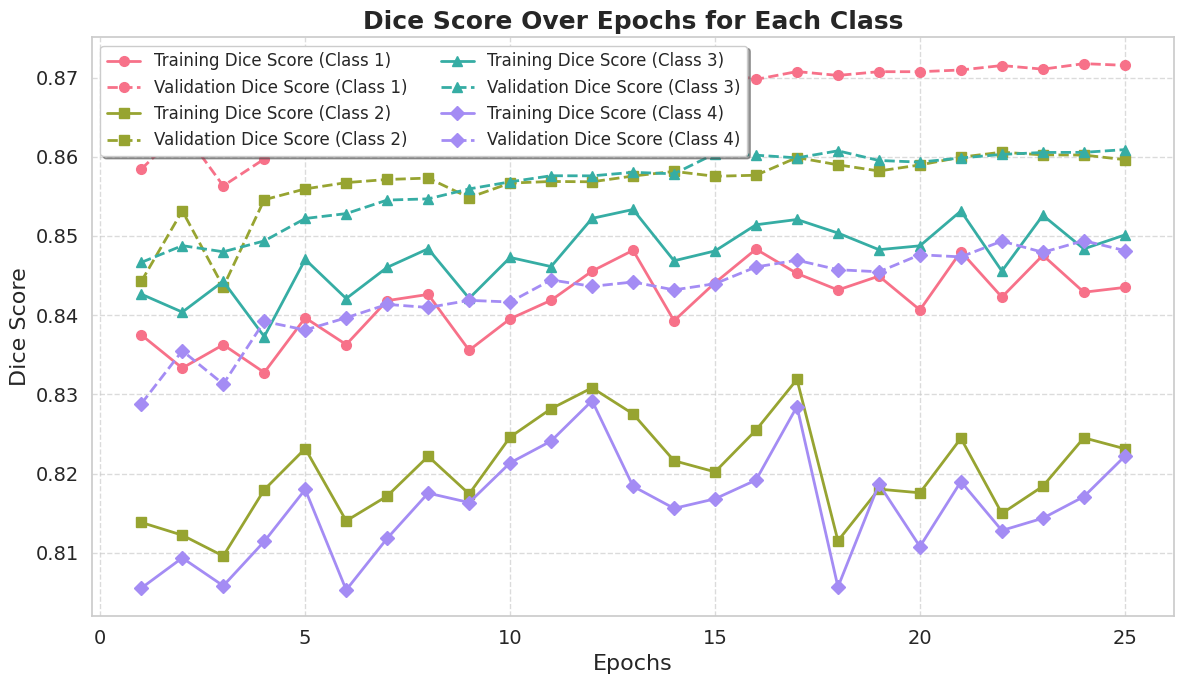

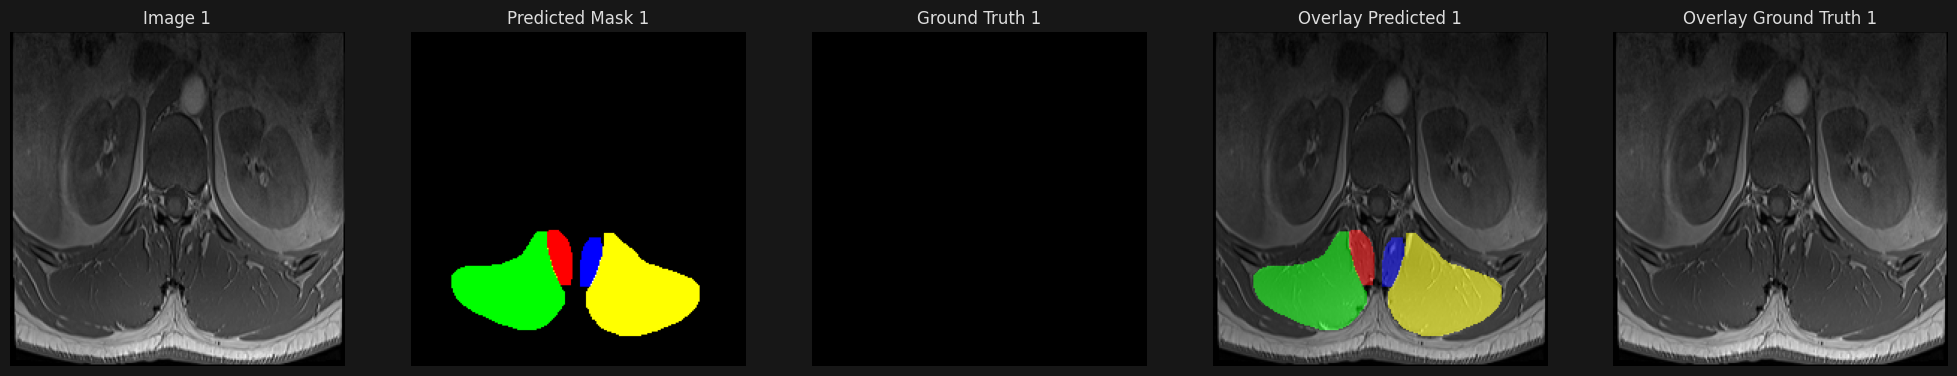

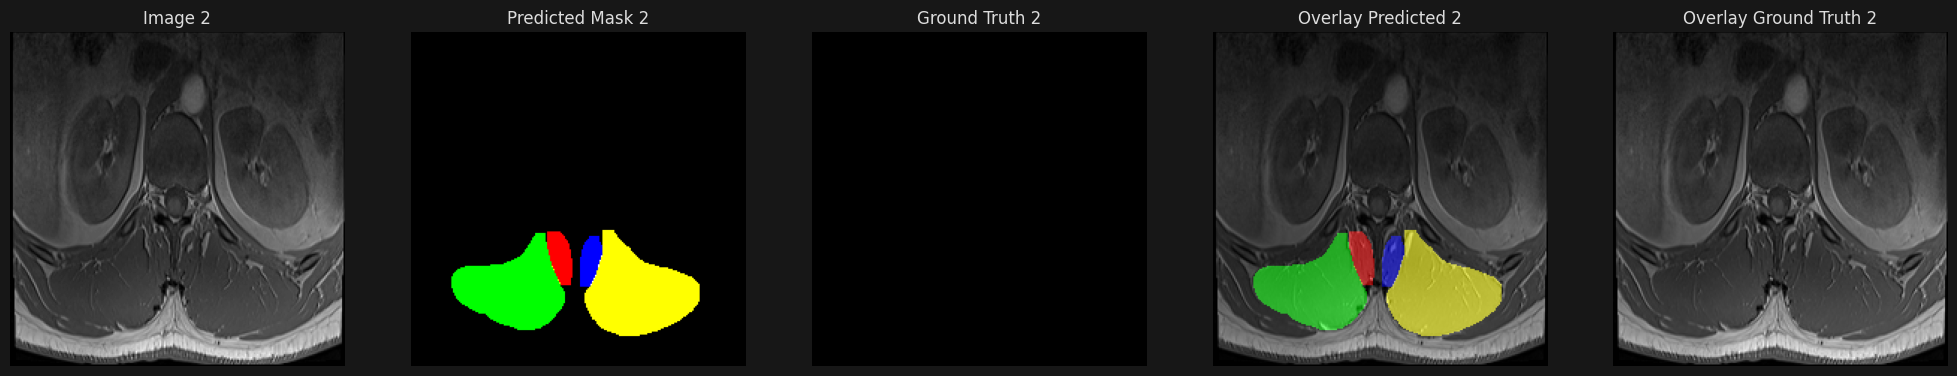

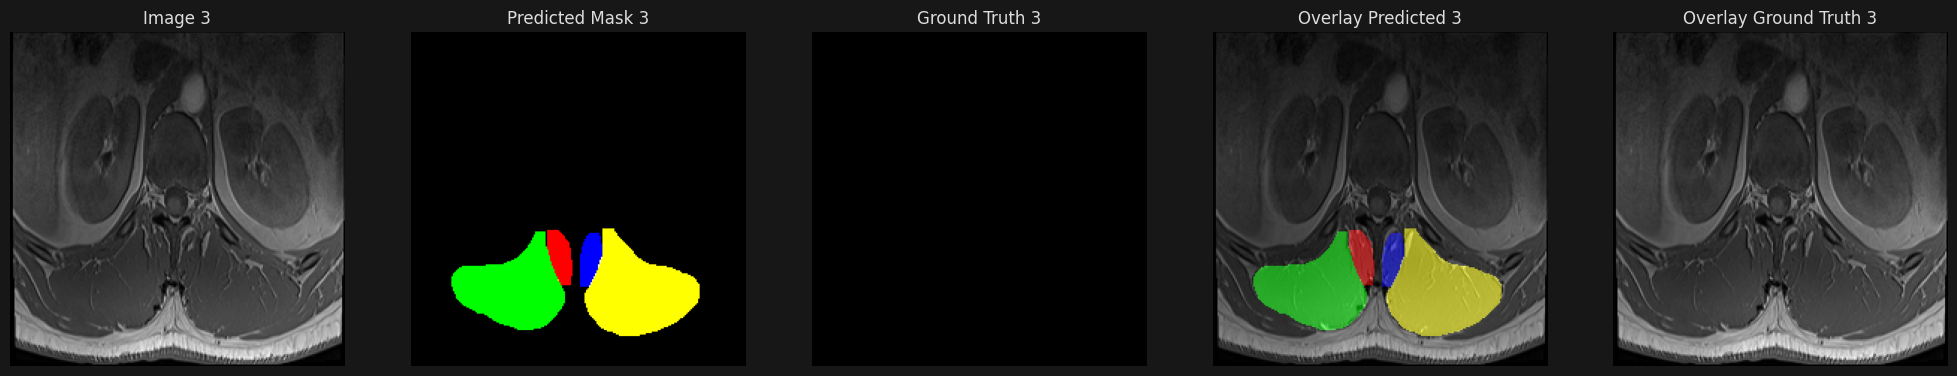

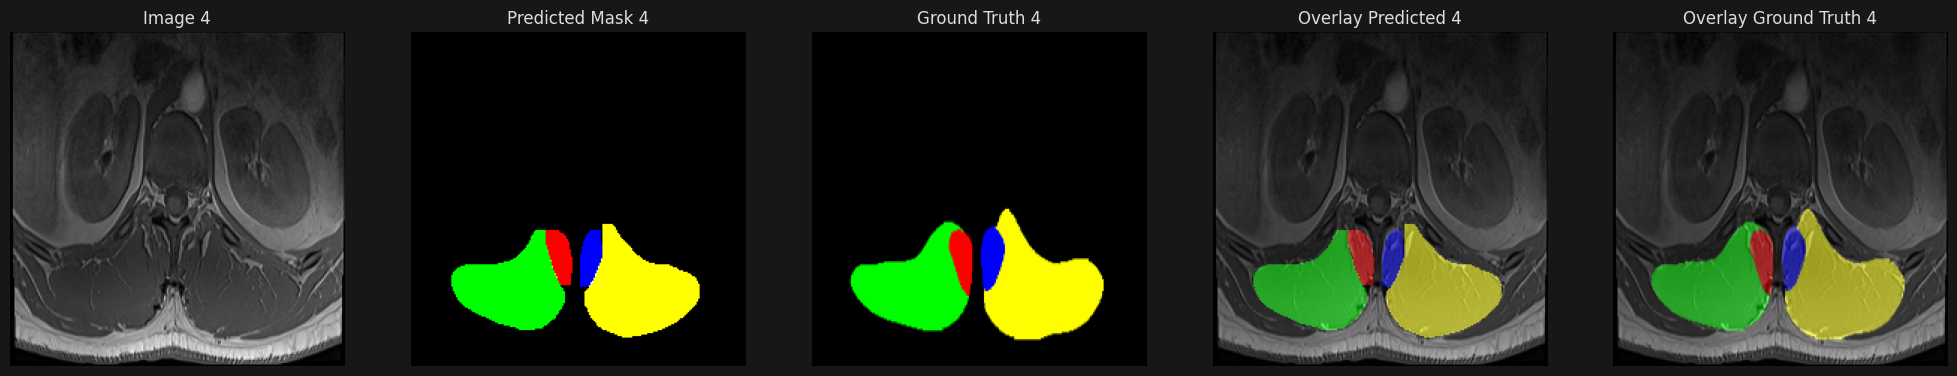

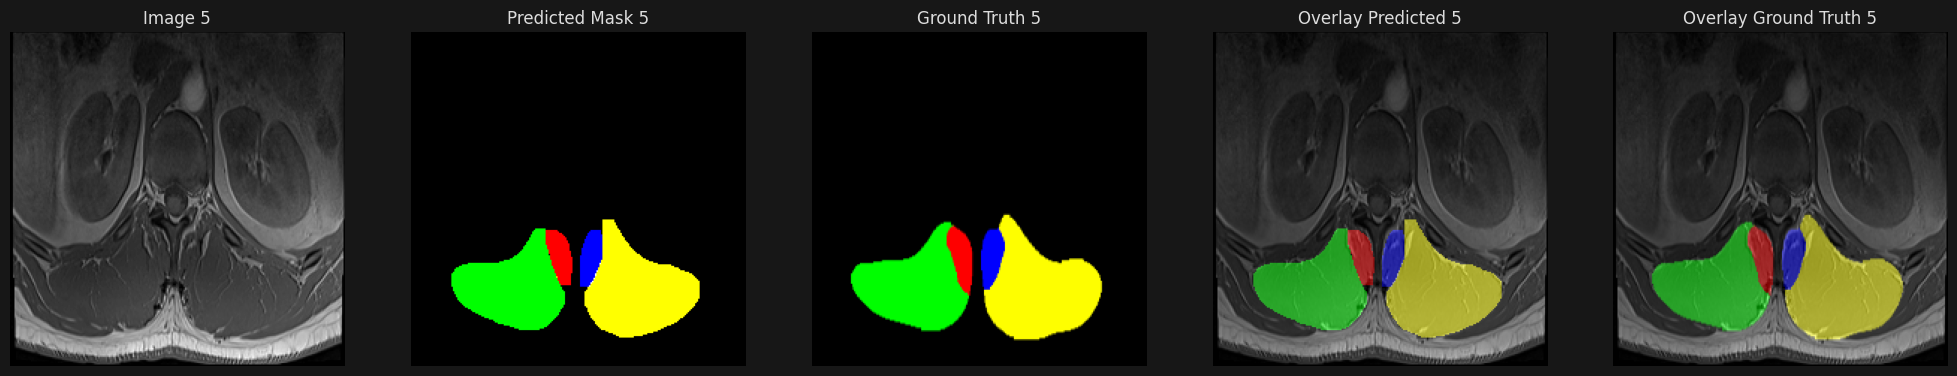

In [28]:
import torch
from torch.amp import GradScaler, autocast
from torch.utils.data import DataLoader
from tqdm import tqdm

# Set up your training configuration
train_config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs': 75,
    'batch_size': 32,
    'learning_rate': 1e-3,  
    'batches_per_epoch': 64,
    'checkpoint_every': 5  # Saving more frequently
}

# Initialize the model
model = ResidualUNet()
model.apply(init_weights)
count_parameters(model)
device = train_config['device']
print(device)
model.to(device)

# Initialize optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=train_config['learning_rate'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3, eps=1e-6
)

# Determine if training should resume from a checkpoint
resume_training = True  # Set to True if you want to resume from a checkpoint

if resume_training:
    start_epoch = load_checkpoint(
        model, optimizer, scheduler,
        checkpoint_dir='checkpoints',
        filename='res_checkpoint.pth'
    )
    start_epoch += 1  # Start from the next epoch after the checkpoint

    # Manually reset the learning rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = train_config['learning_rate']
    print(f"Learning rate reset to {train_config['learning_rate']}")
else:
    start_epoch = 1

# Load the preprocessed dataset
data_path = '/mnt/d/data/data_preprocessed.hdf5'
train_dataset = PreprocessedHDF5Dataset(data_path)

# Create the dataloaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=False)

# Define the CombinedLoss class
class CombinedLoss(torch.nn.Module):
    def __init__(self, weight_dice=1.0, weight_bce=1.0):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.bce_loss = torch.nn.BCEWithLogitsLoss()
        self.weight_dice = weight_dice
        self.weight_bce = weight_bce

    def forward(self, inputs, targets):
        dice = self.dice_loss(inputs, targets)
        bce = self.bce_loss(inputs, targets)
        return self.weight_dice * dice + self.weight_bce * bce

# Initialize GradScaler for mixed precision
scaler = GradScaler()

# Updated training loop with gradient clipping and validation improvements
def train_model(model, train_dataloader, val_dataloader, config, optimizer, scheduler, start_epoch=1, verbose=True):
    device = config['device']
    n_epochs = config['n_epochs']
    batches_per_epoch = config['batches_per_epoch']
    num_classes = 4
    checkpoint_every = config.get('checkpoint_every', 5)

    model.to(device)
    loss_fn = CombinedLoss(weight_dice=1.0, weight_bce=1.0)
    scaler = GradScaler()

    train_epoch_losses = []
    val_epoch_losses = []
    train_epoch_dice_scores = []
    val_epoch_dice_scores = []

    print("Training...")
    for epoch in range(start_epoch, n_epochs + 1):
        model.train()
        train_epoch_loss = 0
        train_epoch_dice = [0.0] * num_classes
        train_loader = tqdm(train_dataloader, desc=f"Epoch {epoch} [Training]", leave=False)

        for train_batch_idx, (train_inputs, train_targets) in enumerate(train_loader, start=1):
            train_inputs = train_inputs.to(device)
            train_targets = train_targets.to(device)

            optimizer.zero_grad()

            # Use autocast with 'device_type' argument
            with autocast(device_type='cuda', dtype=torch.float16):
                train_preds = model(train_inputs)
                train_batch_loss = loss_fn(train_preds, train_targets)

            scaler.scale(train_batch_loss).backward()

            # Apply gradient clipping to stabilize training
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            scaler.step(optimizer)
            scaler.update()

            train_epoch_loss += train_batch_loss.item()
            train_batch_dice = dice_coefficient(train_preds, train_targets, num_classes)
            train_epoch_dice = [sum(x) for x in zip(train_epoch_dice, train_batch_dice)]

            if train_batch_idx >= batches_per_epoch:
                train_loader.close()
                break

        train_epoch_losses.append(train_epoch_loss / batches_per_epoch)
        train_epoch_dice_scores.append([x / batches_per_epoch for x in train_epoch_dice])

        # Validation step remains unchanged
        model.eval()
        val_epoch_loss = 0
        val_epoch_dice = [0.0] * num_classes
        val_loader = tqdm(val_dataloader, desc=f"Epoch {epoch} [Validation]", leave=False)
        with torch.no_grad():
            for val_batch_idx, (val_inputs, val_targets) in enumerate(val_loader, start=1):
                val_inputs = val_inputs.to(device)
                val_targets = val_targets.to(device)

                with autocast(device_type='cuda', dtype=torch.float16):
                    val_preds = model(val_inputs)
                    val_batch_loss = loss_fn(val_preds, val_targets)
                val_epoch_loss += val_batch_loss.item()

                val_batch_dice = dice_coefficient(val_preds, val_targets, num_classes)
                val_epoch_dice = [sum(x) for x in zip(val_epoch_dice, val_batch_dice)]

                if val_batch_idx >= batches_per_epoch:
                    val_loader.close()
                    break

        val_epoch_losses.append(val_epoch_loss / batches_per_epoch)
        val_epoch_dice_scores.append([x / batches_per_epoch for x in val_epoch_dice])

        scheduler.step(val_epoch_loss / batches_per_epoch)

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch: {epoch}, Train loss: {train_epoch_loss:.6f}, Val loss: {val_epoch_loss:.6f}, "
              f"Train Dice: {sum(train_epoch_dice) / num_classes:.6f}, "
              f"Val Dice: {sum(val_epoch_dice) / num_classes:.6f}, "
              f"lr {current_lr:.6e}")

        if epoch % checkpoint_every == 0:
            save_checkpoint(model, optimizer, scheduler, epoch)

    return train_epoch_losses, val_epoch_losses, train_epoch_dice_scores, val_epoch_dice_scores

# Train the model
train_epoch_losses, val_epoch_losses, train_epoch_dice_scores, val_epoch_dice_scores = train_model(
    model, train_dataloader, val_dataloader, train_config,
    optimizer, scheduler, start_epoch, verbose=False
)

# Save the final model
save_model(model, '/mnt/d/data/clean75_unet_model.pth')

# Plot losses
plot_losses(train_epoch_losses, val_epoch_losses)

# Plot Dice scores
plot_dice_scores(train_epoch_dice_scores, val_epoch_dice_scores)

# Get a batch from the validation dataloader
test_inputs, test_targets = next(iter(val_dataloader))

# Display test samples
display_test_samples(model, test_inputs, test_targets, device, num_images_to_display=5)


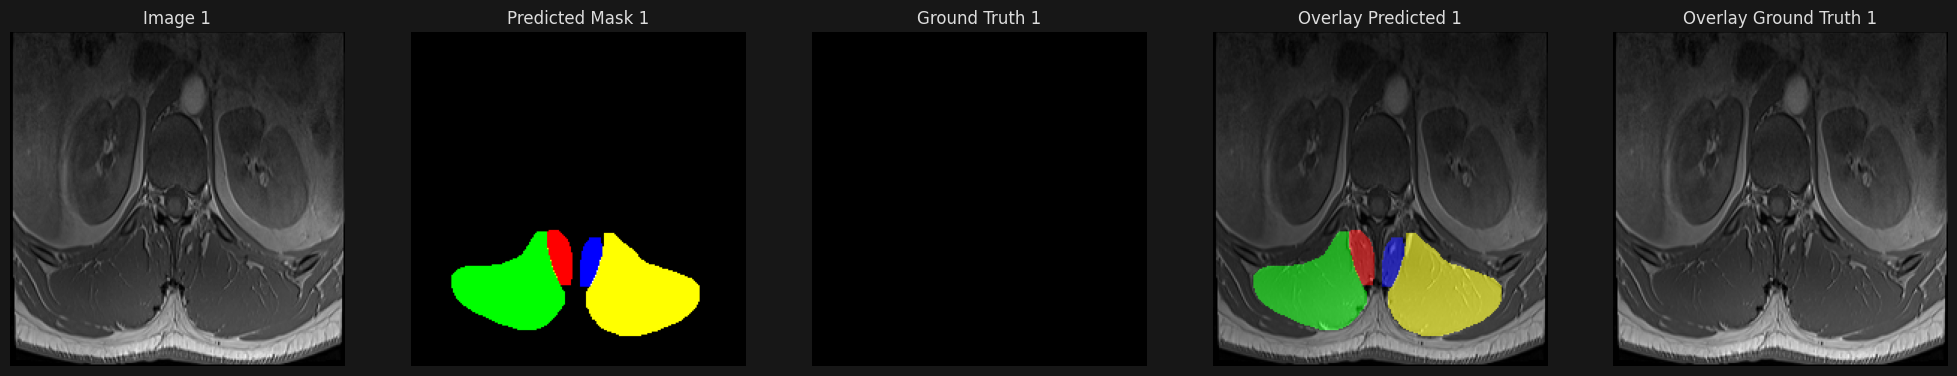

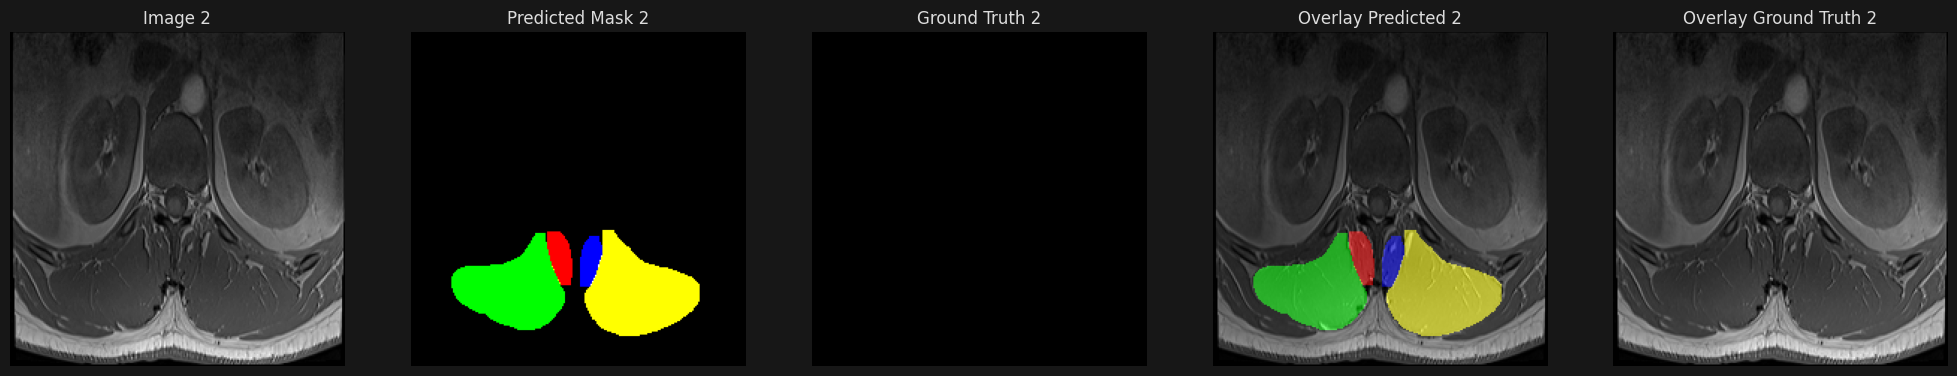

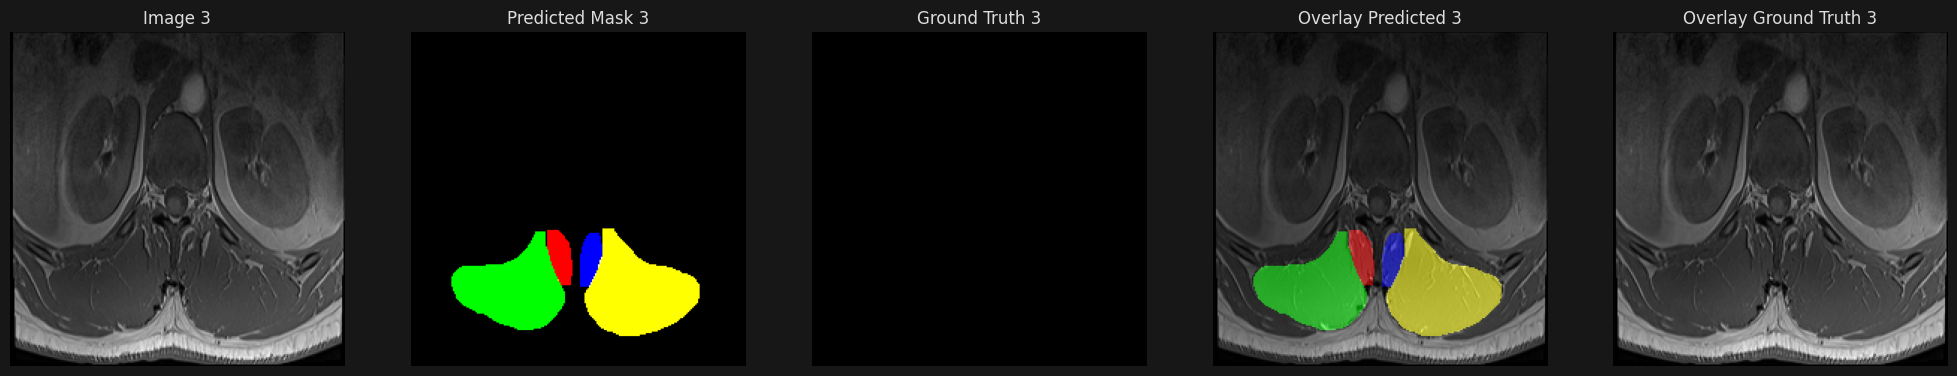

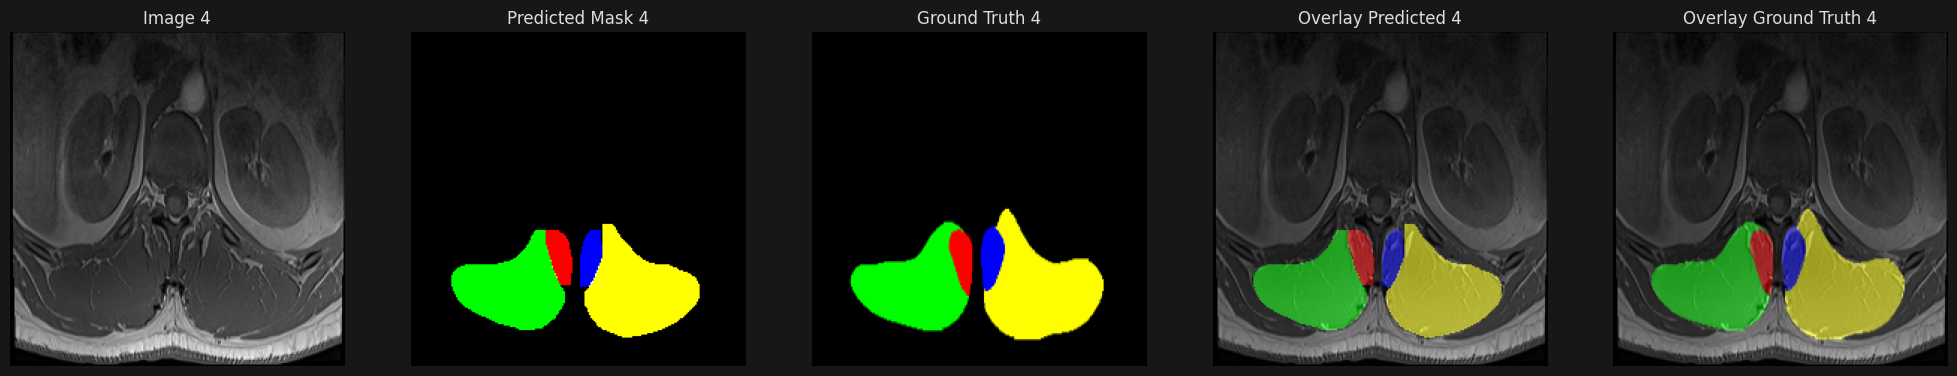

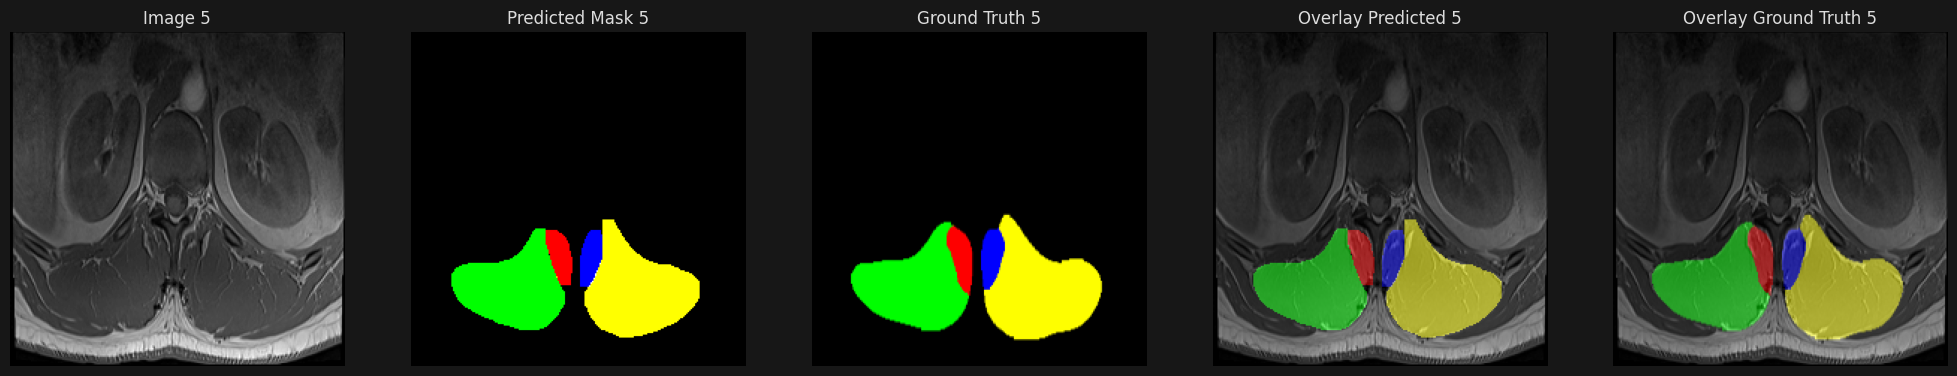

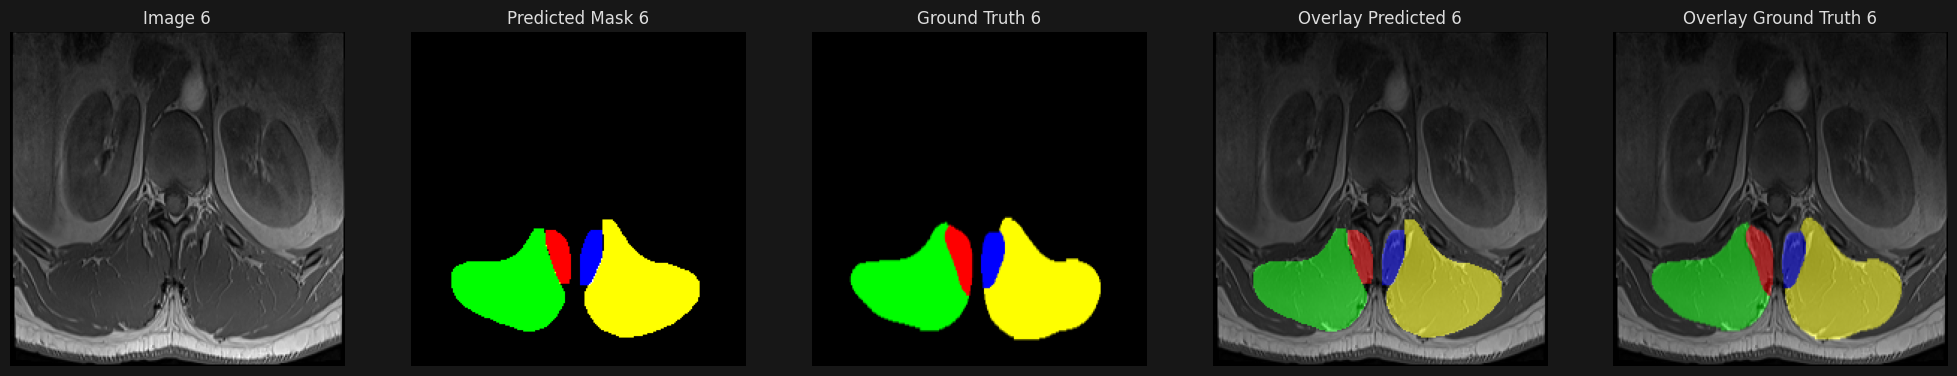

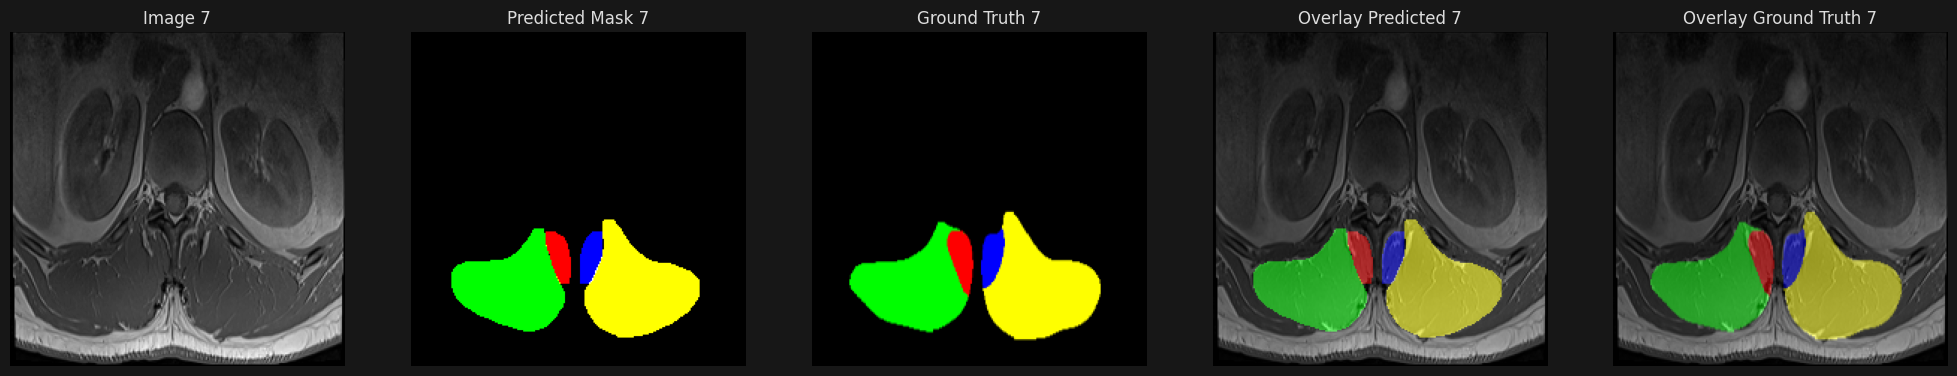

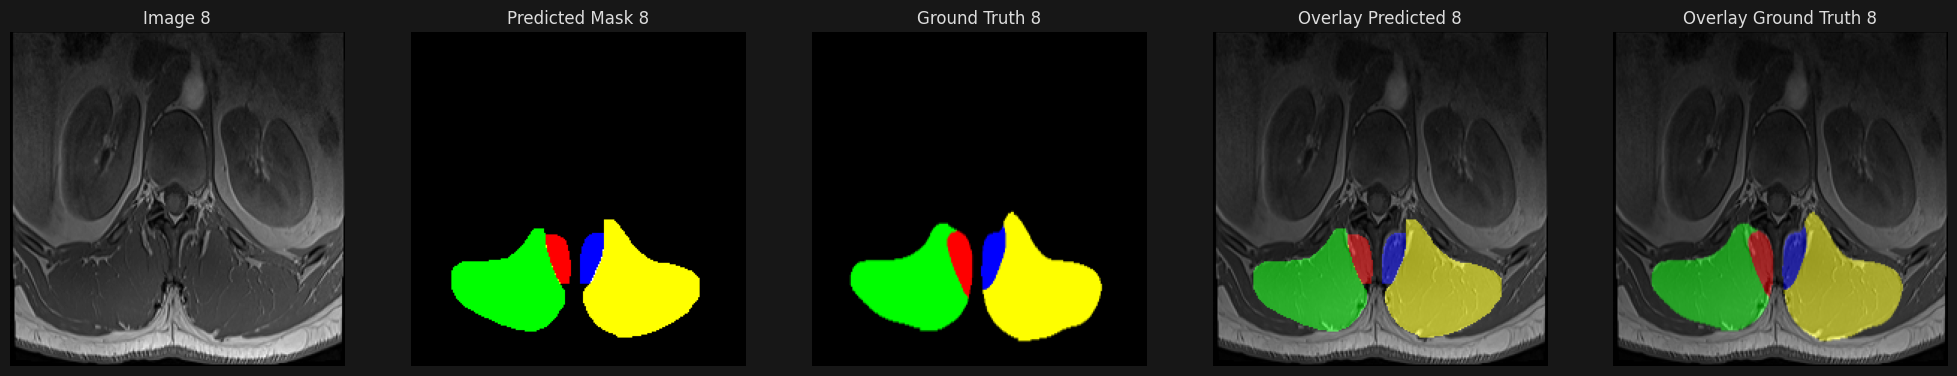

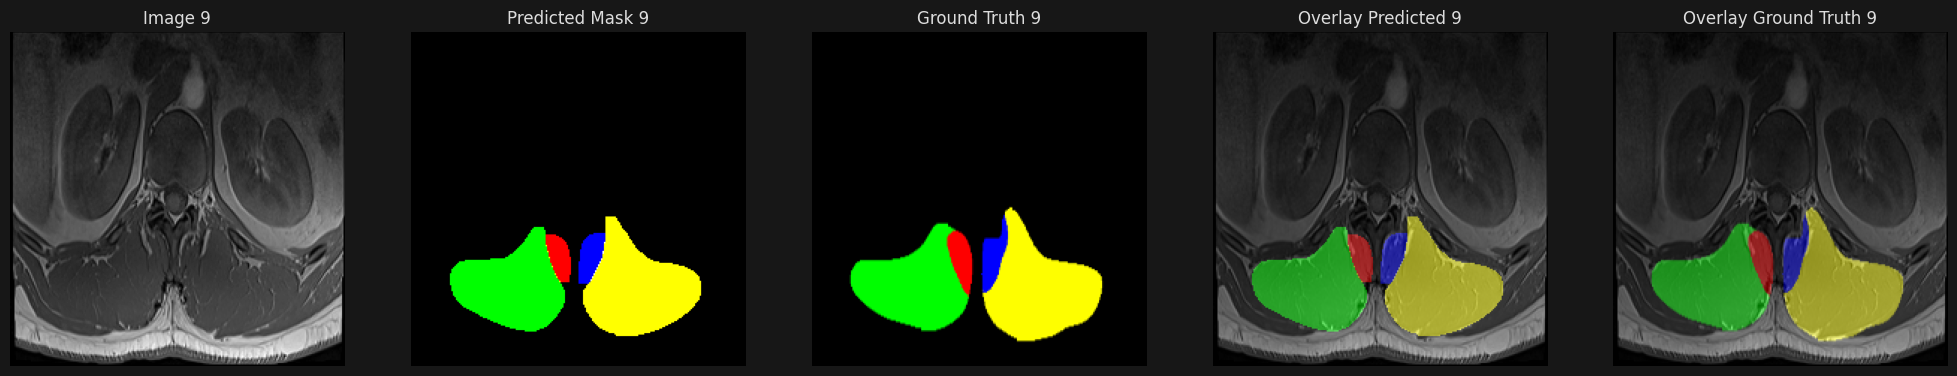

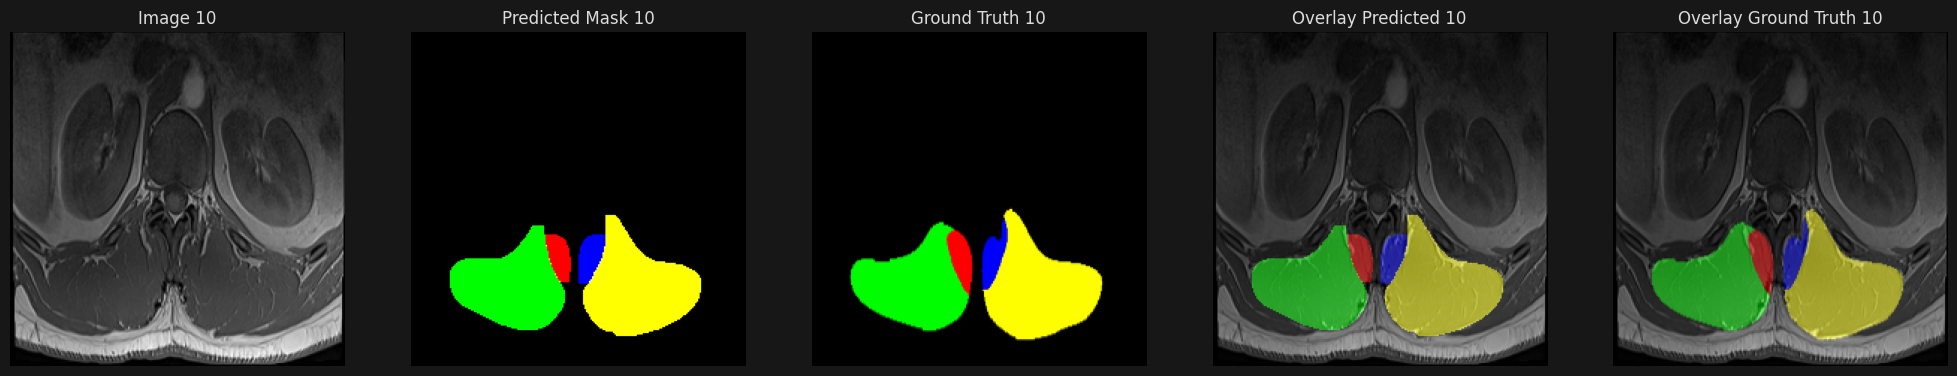

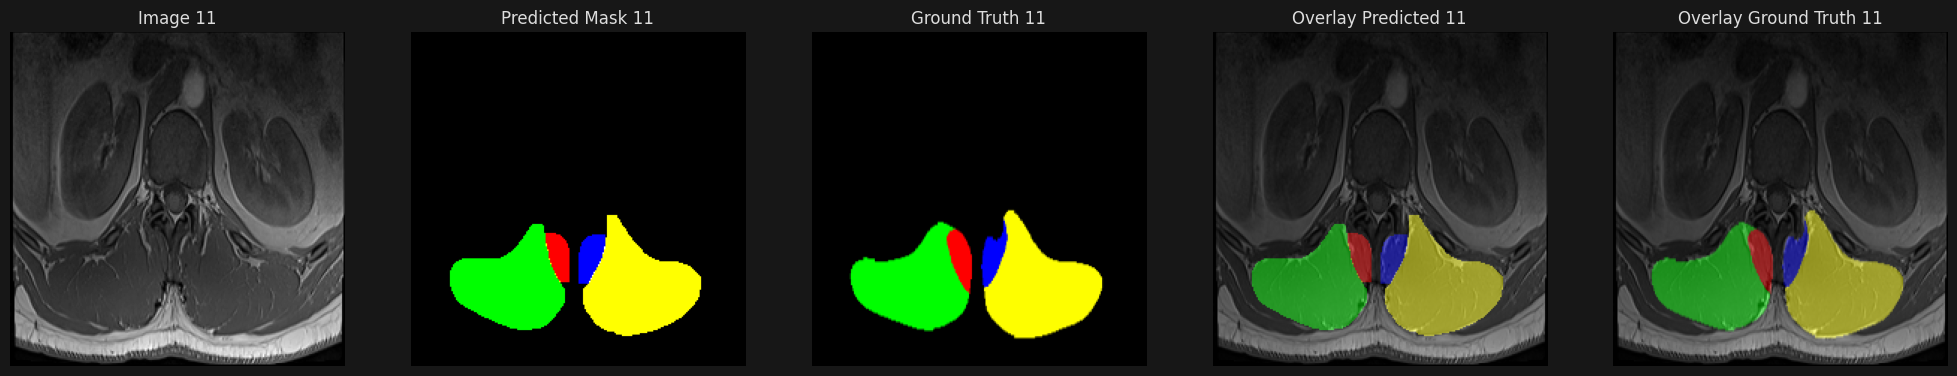

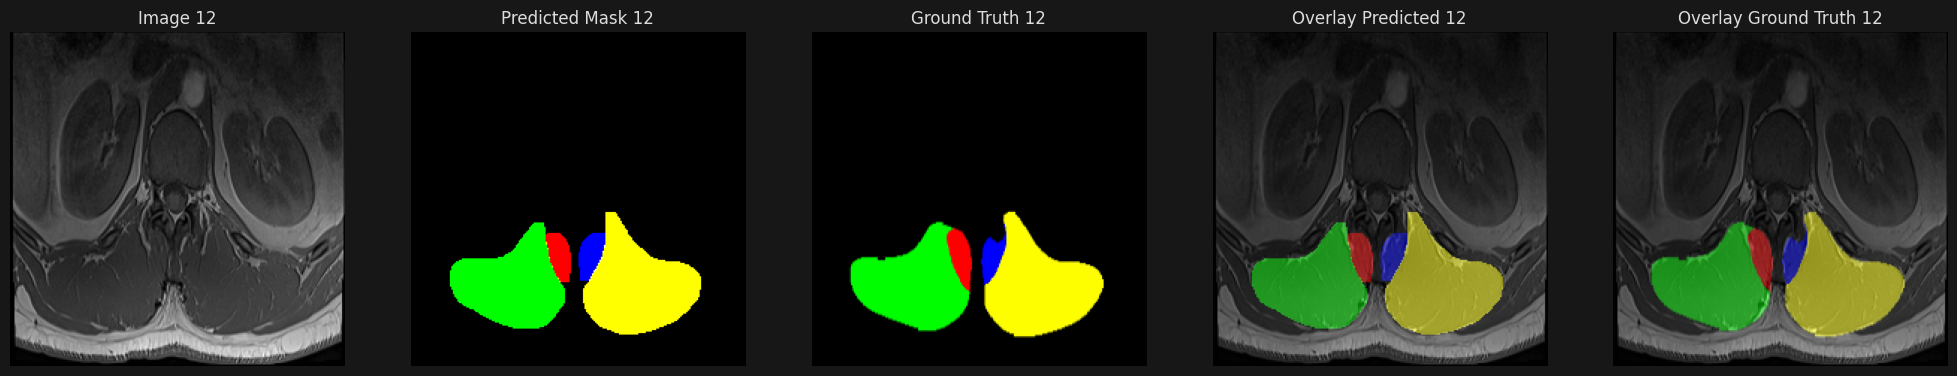

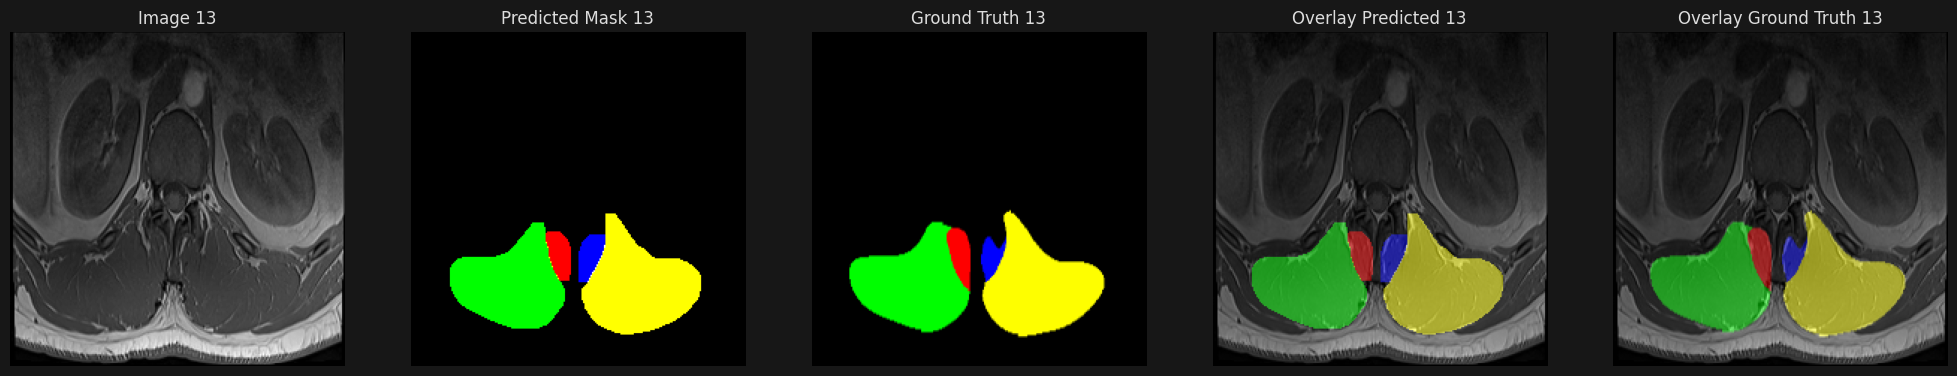

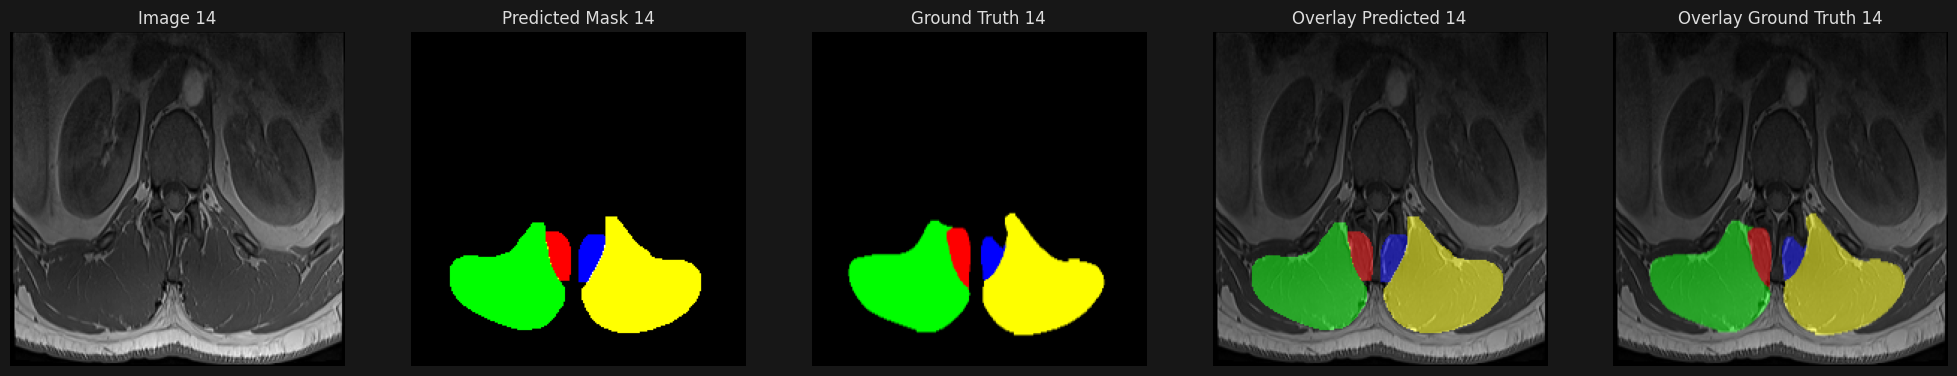

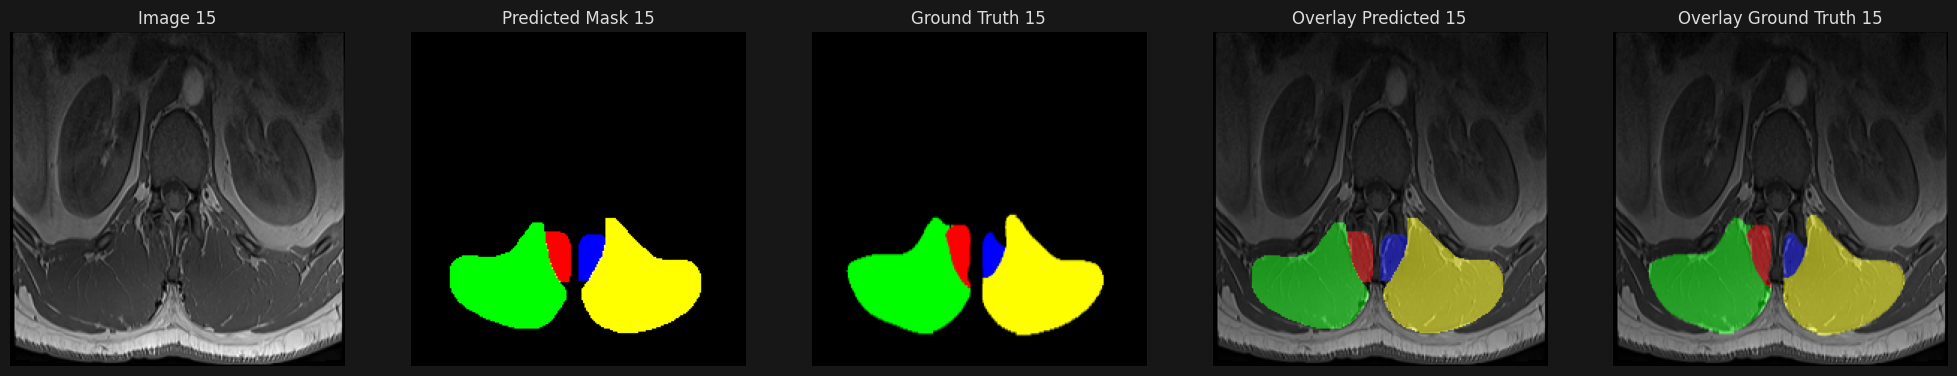

In [29]:
display_test_samples(model, test_inputs, test_targets, device, num_images_to_display=15)